In [1]:
import os
import itertools

import numpy as np
import pandas as pd

### Define Hyperparameters and Save Paths

In [2]:
CONTINENTS = ["Africa", "North America", "South America", "Oceania", "Eastern Europe", "Western Europe", "Middle East", "South Asia", "Southeast-East Asia", "Central Asia"]
WINDOW_SIZE = 7
RECURSIVE_WINDOW_LENGTH = 30
NODES_TO_PERTURB = 5  # 3 means that 1, 2, or 3 nodes might be perturbed
MODEL_IDXS = list(range(10))  # list(range(80, 100))
SAVE_PATH = "./runs/2022-04-16-00_41_22/models{}-{}".format(MODEL_IDXS[0], MODEL_IDXS[-1])

SENSITIVITY_ORDER = ["Western Europe", "North America", "Middle East", "Eastern Europe", "Southeast-East Asia", "Oceania", "South America", "South Asia", "Africa", "Central Asia"]
SENSITIVITY_ORDER_IDX = [CONTINENTS.index(SENSITIVITY_ORDER[i]) for i in range(len(SENSITIVITY_ORDER))]
PERTURBATION_STEPS = [-0.25, -0.5, -0.75]

In [3]:
SAVE_PATH

'./runs/2022-04-16-00_41_22/models0-9'

### Create Combinations of Perturbations

In [4]:
all_perturbations = []

# Create all combinations of perturbation policies
for num_nodes_to_pert in range(1, NODES_TO_PERTURB + 1):  # 3 means 1, 2, then 3 nodes are perturbed at once
    combinations_list = [p for p in itertools.product(PERTURBATION_STEPS, repeat=num_nodes_to_pert)]
    # print(combinations_list, "\n", len(combinations_list), "\n")

    for combo_tuple in combinations_list:
        # length of combo tuple = num_nodes to perturb
        perturb_node_steps = [0,0,0,0,0,0,0,0,0,0]
        for idx, val in enumerate(combo_tuple):
            perturb_node_steps[idx] = val
        # print(perturb_node_steps)

        all_perturbations.append(perturb_node_steps)

In [5]:
print(len(all_perturbations))
all_perturbations[10]

363


[-0.75, -0.5, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
all_perturbations = np.array(all_perturbations)
all_perturbations.shape

(363, 10)

### Load saved prediction array

In [7]:
total_prediction_array = np.load(os.path.join(SAVE_PATH, "models_{}-{}_predictions.npy".format(MODEL_IDXS[0], MODEL_IDXS[-1])))
total_prediction_array.shape

(10, 364, 523, 30, 10)

Convert from log scale to real number scale

In [8]:
total_prediction_array = np.power(10, total_prediction_array, where=total_prediction_array != 0)
total_prediction_array.max()

380467.44

(10, 364, 523, 30, 10) = (num_models, num_dataloaders, num_rolling_windows, recursive_pred_len, 10 nodes)

In [9]:
unperturbed_predictions = total_prediction_array[:,0]
print(unperturbed_predictions.shape)

perturb_combo_predictions = total_prediction_array[:,1:]
print(perturb_combo_predictions.shape)

(10, 523, 30, 10)
(10, 363, 523, 30, 10)


### Calculate Sum of Difference On Each Window

In [10]:
dataloader_window_sum_differences = np.zeros((perturb_combo_predictions.shape[0], perturb_combo_predictions.shape[1], perturb_combo_predictions.shape[2]))
dataloader_window_sum_differences.shape

(10, 363, 523)

In [11]:
"""
This cell contains code which loops over windows and then dataloaders each representing a different perturbation 
combination.
Steps:
1. Compute global sum of COVID cases on each day in recursive prediction window (30 days) for unperturbed and perturbed
2. Subtract perturbed - unperturbed on each day, sum up difference across 30 days
3. Sum of difference is obtained for each window, save into np array
"""
for model_idx in range(dataloader_window_sum_differences.shape[0]):
    for window_idx in range(dataloader_window_sum_differences.shape[2]):
        # Sum nodes to calculate global cases for each of the 30 days of unperturbed recursive prediction
        unpert_global_cases_sum = unperturbed_predictions[:, window_idx].sum(axis=-1)  # Shape (10, 30)
        
        for dataloader_idx in range(dataloader_window_sum_differences.shape[1]):
            # Sum nodes to calculate global cases for each of the 30 days of perturbed recursive prediction
            pert_global_cases_sum = perturb_combo_predictions[:, dataloader_idx, window_idx].sum(axis=-1)  # Shape (10, 30,)
            
            # Subtract perturbed - unperturbed, shape (10, 30,)
            differences = pert_global_cases_sum - unpert_global_cases_sum
            differences = np.abs(differences)  # Take absolute difference
            window_summed_difference = differences.sum(axis=-1)  # Sum up across 30 days, shape (10,)
            
            # Place into dataloader_window_sum_differences for later computation
            dataloader_window_sum_differences[:, dataloader_idx, window_idx] = window_summed_difference


In [12]:
print(dataloader_window_sum_differences.shape)
# dataloader_window_sum_differences

(10, 363, 523)


### Aggregate Across Model and Window Dimensions
For now, assuming that aggregation will be mean. Take mean summed difference across all models

In [13]:
model_window_difference_mean = dataloader_window_sum_differences.mean(axis=0)
model_window_difference_mean.shape

(363, 523)

Then take mean across window dimension, calculate standard deviation as well

In [14]:
window_difference_mean = model_window_difference_mean.mean(axis=-1)
window_difference_mean_normalized = window_difference_mean / window_difference_mean.max()
window_difference_std = model_window_difference_mean.std(axis=-1)
window_difference_mean.shape

(363,)

### Create Spreadsheet

In [15]:
all_perturbations.shape

(363, 10)

In [16]:
spreadsheet_dict = {}
for idx in range(10):
    spreadsheet_dict[SENSITIVITY_ORDER[idx]] = all_perturbations[:, idx]
spreadsheet_dict["Mean Model Mean Window Summed Difference"] = window_difference_mean
spreadsheet_dict["Mean Model Mean Window Summed Difference Normalized"] = window_difference_mean_normalized
spreadsheet_dict["Standard Deviation Across Windows"] = window_difference_std

In [17]:
spreadsheet_df = pd.DataFrame(spreadsheet_dict)
spreadsheet_df.shape

(363, 13)

In [18]:
# Save to excel file
spreadsheet_df.to_excel(os.path.join(SAVE_PATH, "models_{}-{}_spreadsheet_unsigned.xlsx".format(MODEL_IDXS[0], MODEL_IDXS[-1])))

### Plot Perturbation Policy Magnitude versus Policy Impact

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
perturbation_policy_sums = all_perturbations.sum(axis=-1)
perturbation_policy_sums.shape

(363,)

In [21]:
window_difference_mean_normalized.shape

(363,)

In [22]:
def plot_policy_magnitude_vs_impact(perturbation_policy_sums, window_difference_mean_normalized):
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=perturbation_policy_sums, y=window_difference_mean_normalized)
    plt.title("Perturbation Policy Magnitude Sum vs Impact")
    plt.xlabel("Perturbation Policy Summed Magnitude")
    plt.ylabel("Policy Impact")
    plt.gca().invert_xaxis()
    plt.savefig(os.path.join(SAVE_PATH, "policy_magnitude_vs_impact.png"), facecolor="white", bbox_inches="tight")
    plt.show()

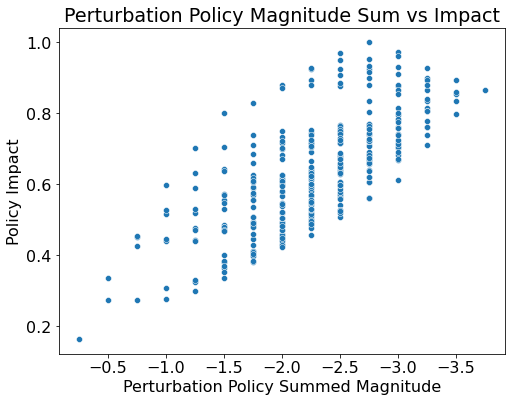

In [23]:
plot_policy_magnitude_vs_impact(perturbation_policy_sums, window_difference_mean_normalized)

In [24]:
policy_sums_df = pd.DataFrame({
    "Policy Magnitude Sum": perturbation_policy_sums,
    "Policy Impact": window_difference_mean_normalized
})
policy_sums_df.shape

(363, 2)

In [25]:
policy_sums_df.head()

,Policy Magnitude Sum,Policy Impact
0,-0.25,0.164016
1,-0.50,0.334724
2,-0.75,0.451033
3,-0.50,0.272794
4,-0.75,0.425253


In [26]:
policy_sums_averages = policy_sums_df.groupby(["Policy Magnitude Sum"], as_index=False).mean()
policy_sums_averages.head(15)

,Policy Magnitude Sum,Policy Impact
0,-3.75,0.867299
1,-3.50,0.848460
2,-3.25,0.821716
3,-3.00,0.778131
4,-2.75,0.727125
5,-2.50,0.671491
6,-2.25,0.619083
7,-2.00,0.569789
8,-1.75,0.527097
9,-1.50,0.494821


In [27]:
# Save to excel
policy_sums_averages.to_excel(os.path.join(SAVE_PATH, "models_{}-{}_avg_impact_per_policy_sum.xlsx".format(MODEL_IDXS[0], MODEL_IDXS[-1])))

In [28]:
def plot_policy_magnitude_vs_impact_averages(policy_sums_averages_df):
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=policy_sums_averages_df, x="Policy Magnitude Sum", y="Policy Impact")
    plt.title("Perturbation Policy Magnitude Sum vs Average Impact")
    plt.xlabel("Perturbation Policy Summed Magnitude")
    plt.ylabel("Average Policy Impact")
    plt.gca().invert_xaxis()
    plt.savefig(os.path.join(SAVE_PATH, "policy_magnitude_vs_average_impact.png"), facecolor="white", bbox_inches="tight")
    plt.show()

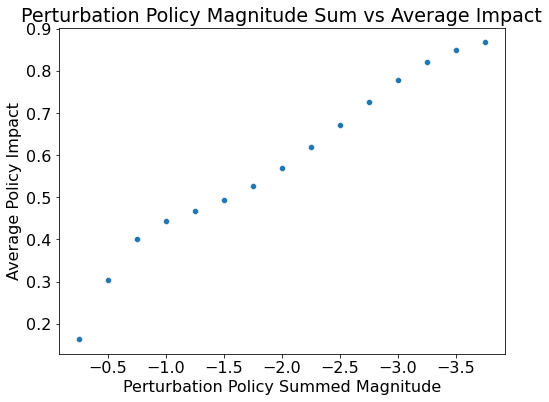

In [29]:
plot_policy_magnitude_vs_impact_averages(policy_sums_averages)

# Analysis and Visualization of Unperturbed vs Most/Medium/Least Impactful Policy

In [30]:
chosen_window = 380

### Plot Trends for Unperturbed cases, strong policy, medium policy, and weak policy

In [31]:
def plot_10_models_unpert_cases(unperturbed_predictions):
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(8,6))

    visual_dict = { "Model {}".format(idx): unperturbed_predictions[idx,chosen_window,:,:].sum(axis=-1) for idx in range(10) }  # Global case trends for 10 models
    visual_dict["Day Index"] = list(range(30))
    visual_df = pd.DataFrame(visual_dict)
    sns.lineplot(data=pd.melt(visual_df, ['Day Index'], value_name="Unperturbed Global Cases", var_name="Model"), x="Day Index", y="Unperturbed Global Cases", hue="Model")

    plt.title("Global Unperturbed Case Predictions on Last Window")
    # plt.xlabel("Day Index")
    # plt.ylabel("Policy Impact")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(SAVE_PATH, "last_window_unpert_global_case_trends.png"), facecolor="white", bbox_inches="tight")
    plt.show()

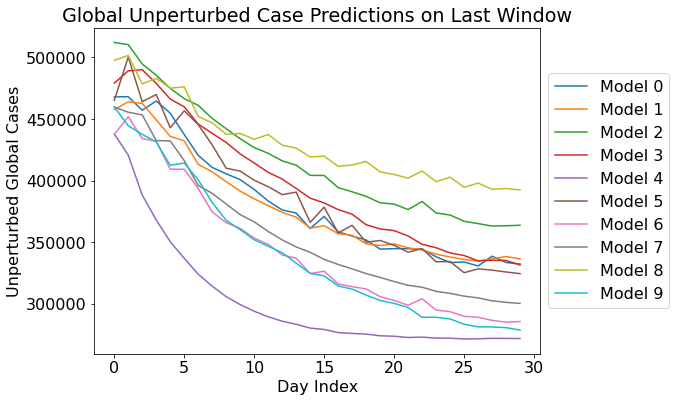

In [32]:
plot_10_models_unpert_cases(unperturbed_predictions)

In [33]:
def plot_10_models_policy_cases(perturb_combo_predictions, policy_idx, policy_desc_str):
    # Index of most impactful policy: 356, [-0.75, -0.75, -0.75, -0.25, -0.25, 0...0]
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(8,6))

    visual_dict = { "Model {}".format(idx): perturb_combo_predictions[idx,policy_idx,chosen_window,:,:].sum(axis=-1) for idx in range(10) }  # Global case trends for 10 models
    visual_dict["Day Index"] = list(range(30))
    visual_df = pd.DataFrame(visual_dict)
    sns.lineplot(data=pd.melt(visual_df, ['Day Index'], value_name="Global Cases", var_name="Model"), x="Day Index", y="Global Cases", hue="Model")

    plt.title("Global Case Predictions on Last Window under {} Impactful Polcy".format(policy_desc_str))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(SAVE_PATH, "last_window_{}_impactful_policy_global_case_trends.png".format(policy_desc_str)), facecolor="white", bbox_inches="tight")
    plt.show()

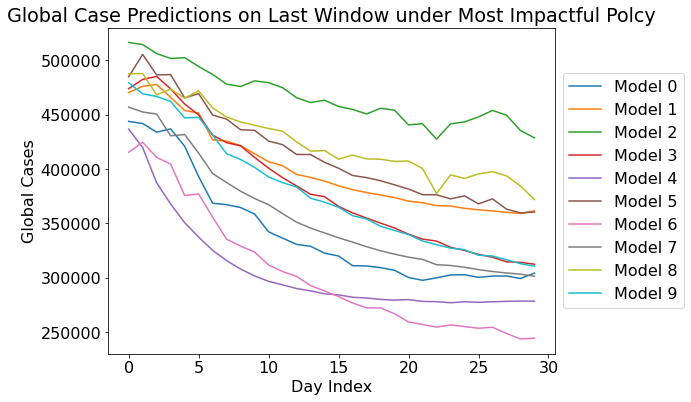

In [34]:
plot_10_models_policy_cases(perturb_combo_predictions, 356, "Most")

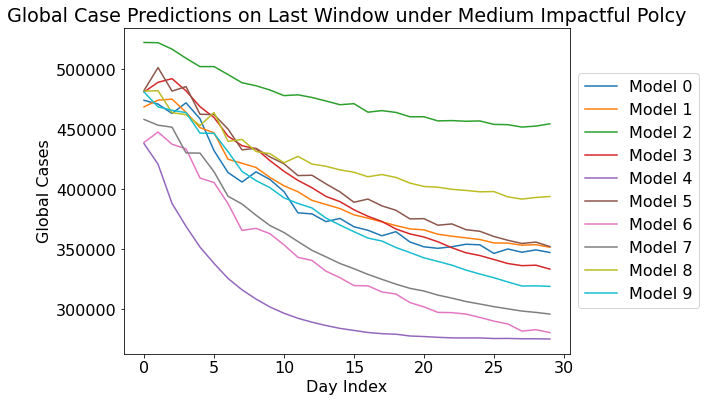

In [35]:
plot_10_models_policy_cases(perturb_combo_predictions, 170, "Medium")

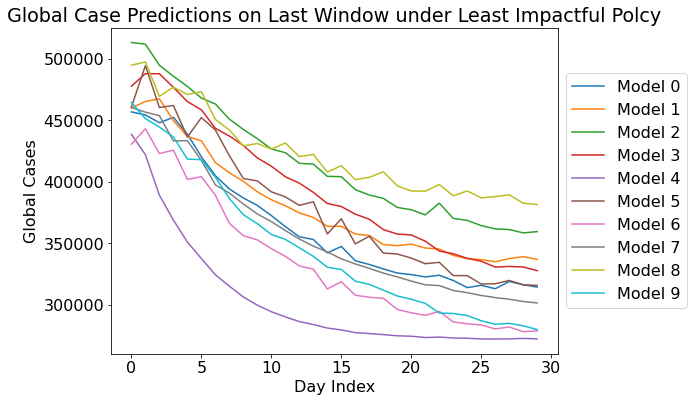

In [36]:
plot_10_models_policy_cases(perturb_combo_predictions, 0, "Least")

### Plot Each model trend figure with 4 curves:
Unperturbed, Most Impactful Policy, Medium Impact Policy, Least Impactful Policy

Create dataset object and use it to plot initial 7 days that start off recursive predictions

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader

class Covid10CountriesPerturbedDataset(Dataset):
    def __init__(self, dataset_npz_path, SENSITIVITY_ORDER_IDX, window_size=7, data_split="entire-dataset-smooth", avg_graph_structure=False, perturb_node_steps=[-0.25,0,0,0,0,0,0,0,0,0]):
        ###########
        # Load data
        ###########
        if data_split == "entire-dataset-smooth" and not avg_graph_structure:
            feature_matrix = np.load(dataset_npz_path)["feature_matrix_smooth"]
            flight_matrix = np.load(dataset_npz_path)["flight_matrix_log10_scaled"]
        elif data_split == "entire-dataset-smooth" and avg_graph_structure:
            feature_matrix = np.load(dataset_npz_path)["feature_matrix_smooth"]
            flight_matrix = np.load(dataset_npz_path)["flight_matrix_unscaled"]
        else:
            raise RuntimeError("Unknown dataset split selected")
        
        assert feature_matrix.shape[0] == flight_matrix.shape[0], "Node feature and edge attribute matrices do not match"
        
        ################################################################
        # Perturb chosen country by deleting incoming and outgoing edges
        ################################################################
        for node_idx, perturb_step in zip(SENSITIVITY_ORDER_IDX, perturb_node_steps):
            flight_matrix[:, node_idx, :] *= (1 + perturb_step)
            flight_matrix[:, :, node_idx] *= (1 + perturb_step)

        self.feature_matrix = feature_matrix
        self.flight_matrix = flight_matrix

        ###############################
        # Create sliding window dataset
        ###############################
        all_window_node_feat = []
        all_window_edge_attr = []
        all_window_edge_idx = []
        all_window_labels = []
        
        for day_idx in range(0, len(feature_matrix) - window_size):
            window_node_feat = []
            window_edge_idx = []
            window_edge_attr = []

            for sub_day in range(day_idx, day_idx + window_size):
                node_data = feature_matrix[sub_day]

                edges_idx_array = np.full((2, 100), -1)
                edges_attr_array = np.full((100), -1).astype(np.float32)
                
                if avg_graph_structure:
                    # Calculate smoothened graph structure across window
                    smoothened_window_flight_matrix = flight_matrix[day_idx: day_idx + window_size].mean(axis=0)  # Shape [10, 10]
                    # Log10 scale now that adjacency is averaged
                    for row in range(len(smoothened_window_flight_matrix)):
                        for col in range(len(smoothened_window_flight_matrix[row])):
                            if smoothened_window_flight_matrix[row][col] > 0:
                                smoothened_window_flight_matrix[row][col] = np.log10(smoothened_window_flight_matrix[row][col])
                    
                    edge_idx = 0
                    for row in range(len(smoothened_window_flight_matrix)):
                        for col in range(len(smoothened_window_flight_matrix[row])):
                            if smoothened_window_flight_matrix[row][col] > 0:
                                edges_idx_array[0][edge_idx] = row  # row is source node
                                edges_idx_array[1][edge_idx] = col  # col is dest node
                                edges_attr_array[edge_idx] = smoothened_window_flight_matrix[row][col]
                                edge_idx += 1
                else:
                    edge_idx = 0
                    for row in range(len(flight_matrix[sub_day])):
                        for col in range(len(flight_matrix[sub_day][row])):
                            if flight_matrix[sub_day][row][col] > 0:
                                edges_idx_array[0][edge_idx] = row
                                edges_idx_array[1][edge_idx] = col
                                edges_attr_array[edge_idx] = flight_matrix[sub_day][row][col]
                                edge_idx += 1
                
                edges_attr_array = np.expand_dims(edges_attr_array, axis=-1)

                window_node_feat.append(np.expand_dims(node_data, axis=0))
                window_edge_idx.append(np.expand_dims(edges_idx_array, axis=0))
                window_edge_attr.append(np.expand_dims(edges_attr_array, axis=0))
            
            window_node_feat = np.concatenate(window_node_feat, axis=0)  # shape (14, 10, 3)
            window_edge_idx = np.concatenate(window_edge_idx, axis=0)  # Shape (14, 2, *num_edges=100)
            window_edge_attr = np.concatenate(window_edge_attr, axis=0)  # Shape (14, *num_edges=100, 1)
            window_labels = feature_matrix[day_idx + window_size, :, 1]  # Shape (10)

            all_window_node_feat.append(np.expand_dims(window_node_feat, axis=0))
            all_window_edge_attr.append(np.expand_dims(window_edge_attr, axis=0))
            all_window_edge_idx.append(np.expand_dims(window_edge_idx, axis=0))
            all_window_labels.append(np.expand_dims(window_labels, axis=0))
        
        self.all_window_node_feat = np.concatenate(all_window_node_feat, axis=0)
        self.all_window_edge_attr = np.concatenate(all_window_edge_attr, axis=0)
        self.all_window_edge_idx = np.concatenate(all_window_edge_idx, axis=0)
        self.all_window_labels = np.concatenate(all_window_labels, axis=0)  # shape (dataset_len, 10)

    def __len__(self):
        return len(self.all_window_labels)
    
    def __getitem__(self, index):
        window_node_feat = self.all_window_node_feat[index].astype(np.float32)  # shape (14, 10, 3)
        window_edge_idx = self.all_window_edge_idx[index]  # shape (14, 2, *num_edges=100)
        window_edge_idx = torch.LongTensor(window_edge_idx)
        window_edge_attr = self.all_window_edge_attr[index]  # shape (14, *num_edges=100, 1)
        window_labels = self.all_window_labels[index]  # shape (10)
        
        return window_node_feat[:,:,1:2], window_edge_idx, window_edge_attr, window_labels

In [38]:
def plot_four_trend_curve_per_model(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict):

    unpert_dataset = Covid10CountriesPerturbedDataset(
        dataset_npz_path="./10_continents_dataset_v19_node_pert.npz",
        SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
        window_size=WINDOW_SIZE,
        data_split="entire-dataset-smooth",
        avg_graph_structure=False,
        perturb_node_steps=[0,0,0,0,0,0,0,0,0,0]
    )
    assert len(unpert_dataset.all_window_edge_attr) - WINDOW_SIZE - RECURSIVE_WINDOW_LENGTH == unperturbed_predictions.shape[1], "Inconsistent window counts."

    # Create first window cases, keep np.nan at end so does not show up on plot
    first_window_cases = np.zeros((RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE, 10))
    first_window_cases[:WINDOW_SIZE,:] = unpert_dataset.all_window_node_feat[chosen_window,:,:,1]
    first_window_cases[first_window_cases == 0] = np.nan
    first_window_cases = np.power(10, first_window_cases, where=first_window_cases != 0)
    # print(first_window_cases.sum(axis=-1))
    first_window_cases = first_window_cases.sum(axis=-1)

    # Index of most impactful policy: 356, [-0.75, -0.75, -0.75, -0.25, -0.25, 0...0]
    for model_index in range(len(MODEL_IDXS)):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(10,8))
        visual_dict = {}
        for key, val in policy_indices_dict.items():
            predictions = perturb_combo_predictions[model_index,key,chosen_window,:,:].sum(axis=-1)
            predictions = np.pad(predictions, (WINDOW_SIZE, 0), "constant", constant_values=(0,0))
            predictions[predictions == 0] = np.nan
            visual_dict["{} Impactful Policy".format(val)] = predictions
        unpert_preds = unperturbed_predictions[model_index,chosen_window,:,:].sum(axis=-1)
        unpert_preds = np.pad(unpert_preds, (WINDOW_SIZE, 0), "constant", constant_values=(0,0))
        unpert_preds[unpert_preds == 0] = np.nan
        visual_dict["Unperturbed Predictions"] = unpert_preds
        visual_dict["Day Index"] = list(range(RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE))
        visual_dict["Starting Input"] = first_window_cases
        visual_df = pd.DataFrame(visual_dict)

        sns.lineplot(data=pd.melt(visual_df, ['Day Index'], value_name="Global Cases", var_name="Varying Policies"), x="Day Index", y="Global Cases", hue="Varying Policies", palette=["green", "blue", "red", "black", "blue"], sizes=[2,2,2,3.5,3.5], size="Varying Policies")

        plt.title("Model {} Global Cases Under Varying Policies".format(model_index))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(os.path.join(SAVE_PATH, "varying_policy_trends_last_window_model_{}.png".format(model_index)), facecolor="white", bbox_inches="tight")
        plt.close()

In [40]:
# Note: Need to change policy indices to select most impactful, medium impact, and least impactful policy
policy_indices_dict = {
    118: "Most",
    283: "Medium",
    0: "Least"
}
plot_four_trend_curve_per_model(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict)

### Plot Continent-wise Change in Predicted Cases
Goal is to investigate why there are more positive models than in node perturbation. </br>
Theory is that multiple nodes are being perturbed, some countries go up.

In [41]:
print(unperturbed_predictions.shape)
print(perturb_combo_predictions.shape)

(10, 523, 30, 10)
(10, 363, 523, 30, 10)


In [42]:
def plot_one_model_node_wise_change_in_prediction(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict, model_idx):
    """
    This function creates 3 figures using the given model's predictions, each figure correspond to one policy
    (most, medium, or least impactful) and will have 20 lines: 10 solid line will be the unperturbed predictions,
    and the dashed lines will be the cases forecasted under the given policy.

    These figures are meant to show node-wise changes in cases based on the policy, and how the changes in cases
    might be summed together. It is also meant to investigate why there are more positive models than in node
    perturbation.
    """
    plot_save_path = os.path.join(SAVE_PATH, "one_model_policy_node_wise_changes")
    if not os.path.exists(plot_save_path):
        os.mkdir(plot_save_path)

    unpert_dataset = Covid10CountriesPerturbedDataset(
        dataset_npz_path="./10_continents_dataset_v19_node_pert.npz",
        SENSITIVITY_ORDER_IDX=SENSITIVITY_ORDER_IDX,
        window_size=WINDOW_SIZE,
        data_split="entire-dataset-smooth",
        avg_graph_structure=False,
        perturb_node_steps=[0,0,0,0,0,0,0,0,0,0]
    )
    assert len(unpert_dataset.all_window_edge_attr) - WINDOW_SIZE - RECURSIVE_WINDOW_LENGTH == unperturbed_predictions.shape[1], "Inconsistent window counts."

    # Create first window cases, keep np.nan at end so does not show up on plot
    first_window_cases = np.zeros((RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE, 10))
    first_window_cases[:WINDOW_SIZE,:] = unpert_dataset.all_window_node_feat[chosen_window,:,:,1]
    first_window_cases[first_window_cases == 0] = np.nan
    first_window_cases = np.power(10, first_window_cases, where=first_window_cases != 0)
    
    for key, val in policy_indices_dict.items():
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(16,12))
        visual_dict_unpert = {}
        visual_dict_pert = {}
        visual_dict_start_input = {}
        for node_idx in range(len(CONTINENTS)):
            unpert_preds = unperturbed_predictions[model_idx,chosen_window,:,node_idx]
            unpert_preds = np.pad(unpert_preds, (WINDOW_SIZE, 0), "constant", constant_values=(0,0))
            unpert_preds[unpert_preds == 0] = np.nan
            visual_dict_unpert[CONTINENTS[node_idx] + " Unperturbed"] = unpert_preds

            pert_preds = perturb_combo_predictions[model_idx,key,chosen_window,:,node_idx]
            pert_preds = np.pad(pert_preds, (WINDOW_SIZE, 0), "constant", constant_values=(0,0))
            pert_preds[pert_preds == 0] = np.nan
            visual_dict_pert[CONTINENTS[node_idx] + " Perturbed"] = pert_preds
        
        for node_idx in range(len(CONTINENTS)):
            visual_dict_start_input["{} Starting Input".format(CONTINENTS[node_idx])] = first_window_cases[:,node_idx]
        visual_dict_unpert["Day Index"] = list(range(RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE))
        visual_dict_pert["Day Index"] = list(range(RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE))
        visual_dict_start_input["Day Index"] = list(range(RECURSIVE_WINDOW_LENGTH + WINDOW_SIZE))

        visual_df_unpert = pd.DataFrame(visual_dict_unpert)
        visual_df_pert = pd.DataFrame(visual_dict_pert)
        visual_df_start_input = pd.DataFrame(visual_dict_start_input)
        sns.lineplot(data=pd.melt(visual_df_unpert, ['Day Index'], value_name="Cases", var_name="Continent"), x="Day Index", y="Cases", hue="Continent")
        sns.lineplot(data=pd.melt(visual_df_pert, ['Day Index'], value_name="Cases", var_name="Continent"), x="Day Index", y="Cases", hue="Continent", linestyle="dashed")
        sns.lineplot(data=pd.melt(visual_df_start_input, ['Day Index'], value_name="Cases", var_name="Continent"), x="Day Index", y="Cases", hue="Continent", linestyle="solid")

        plt.title("Model {} {} Impactful Policy Continent-Wise Changes".format(model_idx, val), fontsize=20)
        plt_legend_lines = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).get_lines()
        for i in range(10, 20):
            plt_legend_lines[i].set_linestyle("--")
        plt.savefig(os.path.join(plot_save_path, "model_{}_{}_policy_node_wise_change.png".format(model_idx, val)), facecolor="white", bbox_inches="tight")
        plt.close()

In [44]:
plot_one_model_node_wise_change_in_prediction(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict, model_idx=6)

In [45]:
def plot_three_trend_unsigned_policy_impact_per_model(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict):
    # Index of most impactful policy: 356, [-0.75, -0.75, -0.75, -0.25, -0.25, 0...0]

    for model_index in range(len(MODEL_IDXS)):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(10,8))
        visual_dict = {}
        for key, val in policy_indices_dict.items():
            visual_dict["{} Impactful Policy".format(val)] = np.abs(perturb_combo_predictions[model_index,key,chosen_window,:,:].sum(axis=-1) - unperturbed_predictions[model_index,chosen_window,:,:].sum(axis=-1))
        visual_dict["Day Index"] = list(range(30))
        visual_df = pd.DataFrame(visual_dict)
        sns.lineplot(data=pd.melt(visual_df, ['Day Index'], value_name="Impact on Cases", var_name="Varying Policies"), x="Day Index", y="Impact on Cases", hue="Varying Policies", palette=["green", "blue", "red"], sizes=[2,2,2], size="Varying Policies")

        plt.title("Model {} Impact on Cases Under Varying Policies".format(model_index))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(os.path.join(SAVE_PATH, "three_policy_unsigned_impact_trends_model_{}.png".format(model_index)), facecolor="white", bbox_inches="tight")
        plt.close()

In [46]:
plot_three_trend_unsigned_policy_impact_per_model(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict)

In [47]:
print(unperturbed_predictions.shape)
print(perturb_combo_predictions.shape)

(10, 523, 30, 10)
(10, 363, 523, 30, 10)


In [48]:
def plot_three_trend_unsigned_policy_impact_average_all_models(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict):
    # Index of most impactful policy: 356, [-0.75, -0.75, -0.75, -0.25, -0.25, 0...0]

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10,8))
    visual_dict = {}
    for key, val in policy_indices_dict.items():
        visual_dict["{} Impactful Policy".format(val)] = np.abs(perturb_combo_predictions[:,key,chosen_window,:,:].sum(axis=-1).mean(axis=0) - unperturbed_predictions[:,chosen_window,:,:].sum(axis=-1).mean(axis=0))
    visual_dict["Day Index"] = list(range(30))
    visual_df = pd.DataFrame(visual_dict)
    sns.lineplot(data=pd.melt(visual_df, ['Day Index'], value_name="Average Impact on Cases", var_name="Varying Policies"), x="Day Index", y="Average Impact on Cases", hue="Varying Policies", palette=["green", "blue", "red"], sizes=[2,2,2], size="Varying Policies")

    plt.title("Average Model Impact on Cases Under Varying Policies")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(SAVE_PATH, "three_policy_unsigned_impact_trends_all_models_avg.png"), facecolor="white", bbox_inches="tight")
    plt.close()

In [49]:
plot_three_trend_unsigned_policy_impact_average_all_models(unperturbed_predictions, perturb_combo_predictions, policy_indices_dict)